In [134]:
! pip install -q qiskit
! pip install -q qiskit-aer
! pip install -q qiskit-algorithms
! pip install -q qiskit-nature
! pip install -q qiskit-nature-pyscf # install the pyscf library
! pip install -q qiskit-ibm-runtime
# print(qiskit.__version__)
# print(qiskit_aer.__version__)
# print(qiskit_algorithms.__version__)
# print(qiskit_nature.__version__)
# print(qiskit_nature_pyscf.__version__)
# print(qiskit_ibm_runtime.__version__)


In [135]:
import qiskit_nature
import qiskit
import qiskit_aer
import qiskit_algorithms
import qiskit_ibm_runtime
import qiskit_nature_pyscf
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.circuit.library import EfficientSU2
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_aer import  AerSimulator
# from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_algorithms.optimizers import SLSQP
from qiskit_aer.primitives import Estimator
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import ParityMapper
from scipy.linalg import eigh
from qiskit_nature.second_q.circuit.library import HartreeFock
from scipy.linalg import expm
from qiskit.quantum_info import Statevector
from numpy import pi

# Analysis of Li atom in 10 spin orbitals:

In [136]:
mdriver = PySCFDriver(
    atom="Li 0.0 0.0 0.0",  # Specify the atom and its coordinates
    basis="sto3g",          # Define the basis set
    charge=0,                # Set the charge of the atom
    spin=1,                 # Set the spin of the atom
    unit=DistanceUnit.ANGSTROM, # Define the unit of the coordinates
)

# You can now use the driver to run a calculation
electronic_structure_problem = mdriver.run()

In [137]:
print("Spatial orbitals:", electronic_structure_problem.num_spatial_orbitals)
print("Number of up spin: ", electronic_structure_problem.num_alpha)
print("Number of down spin: ", electronic_structure_problem.num_beta)
print("\n")
print("Down spin configuration : ", electronic_structure_problem.orbital_occupations_b)
print("Down spin configuration : ",electronic_structure_problem.orbital_occupations)
print("Number of particles: ", electronic_structure_problem.num_particles)
# print(electronic_structure_problem.second_q_ops()[0])

Spatial orbitals: 5
Number of up spin:  2
Number of down spin:  1


Down spin configuration :  [1. 0. 0. 0. 0.]
Down spin configuration :  [1. 1. 0. 0. 0.]
Number of particles:  (2, 1)


In [138]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper

solver = GroundStateEigensolver(
    JordanWignerMapper(),
    NumPyMinimumEigensolver(),
)

result = solver.solve(electronic_structure_problem)
print(result)
print("HF energy : ", electronic_structure_problem.reference_energy)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.315836552851
  - computed part:      -7.315836552851
~ Nuclear repulsion energy (Hartree): 0.0
> Total ground state energy (Hartree): -7.315836552851
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 3.000 S: 0.500 S^2: 0.750 M: -0.129
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.0]
    - computed part:      [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 
HF energy :  -7.315525981281089


In [139]:
mapper = JordanWignerMapper()
qubit_hamiltonian = mapper.map(electronic_structure_problem.second_q_ops()[0])
state = HartreeFock(electronic_structure_problem.num_spatial_orbitals, electronic_structure_problem.num_particles, mapper)
print(state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          
q_4: ─────
     ┌───┐
q_5: ┤ X ├
     └───┘
q_6: ─────
          
q_7: ─────
          
q_8: ─────
          
q_9: ─────
          


In [140]:
from qiskit_algorithms import NumPyEigensolver
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver
numpy_solver = NumPyEigensolver(k=2, filter_criterion=electronic_structure_problem.get_default_filter_criterion())
numpy_excited_states_solver = ExcitedStatesEigensolver(mapper, numpy_solver)
numpy_results = numpy_excited_states_solver.solve(electronic_structure_problem)
# print(numpy_results)

In [141]:
numpy_results.computed_energies

array([], dtype=float64)

In [142]:
statevector = Statevector(state)
k = 3
E_sub = np.zeros((k, k), dtype=complex)
S_sub = np.zeros((k, k), dtype=complex)
for i in range(k):
    for j in range(k):
        U = expm(-(i-j)*pi*1j*qubit_hamiltonian/0.08)

        # Apply the unitary operator to the statevector using evolve()
        evolved_statevector = statevector.evolve(U)

        # Now you can access the data of the evolved statevector
        S_sub[i, j] = statevector.expectation_value(U)

        # Now apply hamiltonian to evolved state
        evolved_statevector = evolved_statevector.evolve(qubit_hamiltonian)
        E_sub[i, j] = statevector.inner(evolved_statevector)

print(E_sub)
print(S_sub)


[[-7.31552598+0.j          1.19033506-7.21691474j  6.92746612+2.35002278j]
 [ 1.19033506+7.21691474j -7.31552598+0.j          1.19033506-7.21691474j]
 [ 6.92746612-2.35002278j  1.19033506+7.21691474j -7.31552598+0.j        ]]
[[ 1.        +0.j         -0.16269265+0.98644957j -0.94691923-0.32125274j]
 [-0.16269265-0.98644957j  1.        +0.j         -0.16269265+0.98644957j]
 [-0.94691923+0.32125274j -0.16269265-0.98644957j  1.        +0.j        ]]


In [143]:
# S_sub = regularize_matrix(S_sub)
eigenvalues, eigenvectors = eigh(E_sub, S_sub)
print(eigenvalues)
print(eigenvectors)
# print(eigenvalues[0]- eigenvalues[1])

[-7.31582811 -5.04744521 -3.15158127]
[[-2.99838934e-01+1.41717490e-01j  2.78362925e+01+1.12324556e+01j
  -1.15697778e+02-6.72269504e+00j]
 [ 6.51695637e-02+3.95044341e-01j  2.33861190e+01+3.14723661e+01j
   5.12364760e+01-1.82587365e+01j]
 [ 3.29470315e-01+3.79017787e-02j  2.72299397e+00+2.98933529e+01j
  -8.53717437e+01+7.83762455e+01j]]


In [144]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA, SPSA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

transformer = FreezeCoreTransformer(remove_orbitals=[3, 4], freeze_core=False)
electronic_structure_problem = transformer.transform(electronic_structure_problem)
ansatz = UCCSD(
    electronic_structure_problem.num_spatial_orbitals,
    electronic_structure_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        electronic_structure_problem.num_spatial_orbitals,
        electronic_structure_problem.num_particles,
        mapper,
    ),
)

estimator = Estimator()
# This first part sets the ground state solver
# see more about this part in the ground state calculation tutorial
solver = VQE(estimator, ansatz, SPSA())
solver.initial_point = [0.0] * ansatz.num_parameters
gse = GroundStateEigensolver(mapper, solver)

# The qEOM algorithm is simply instantiated with the chosen ground state solver and Estimator primitive
qeom_excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)
qeom_results = qeom_excited_states_solver.solve(electronic_structure_problem)

<ipython-input-144-9c2111388627>:20: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [145]:
qeom_results.computed_energies

array([-7.17322247, -7.1201072 , -5.1356603 , -5.10194735, -5.06186018,
       -4.97029674, -4.90329538, -1.82786336, -1.72924969])

In [146]:
exact_eva, exact_eve = eigh(qubit_hamiltonian.to_matrix())
print(exact_eva)

[-7.31583655e+00 -7.31583655e+00 -7.25379126e+00 ... -4.90501018e-01
  1.38777878e-15  3.77428002e-01]


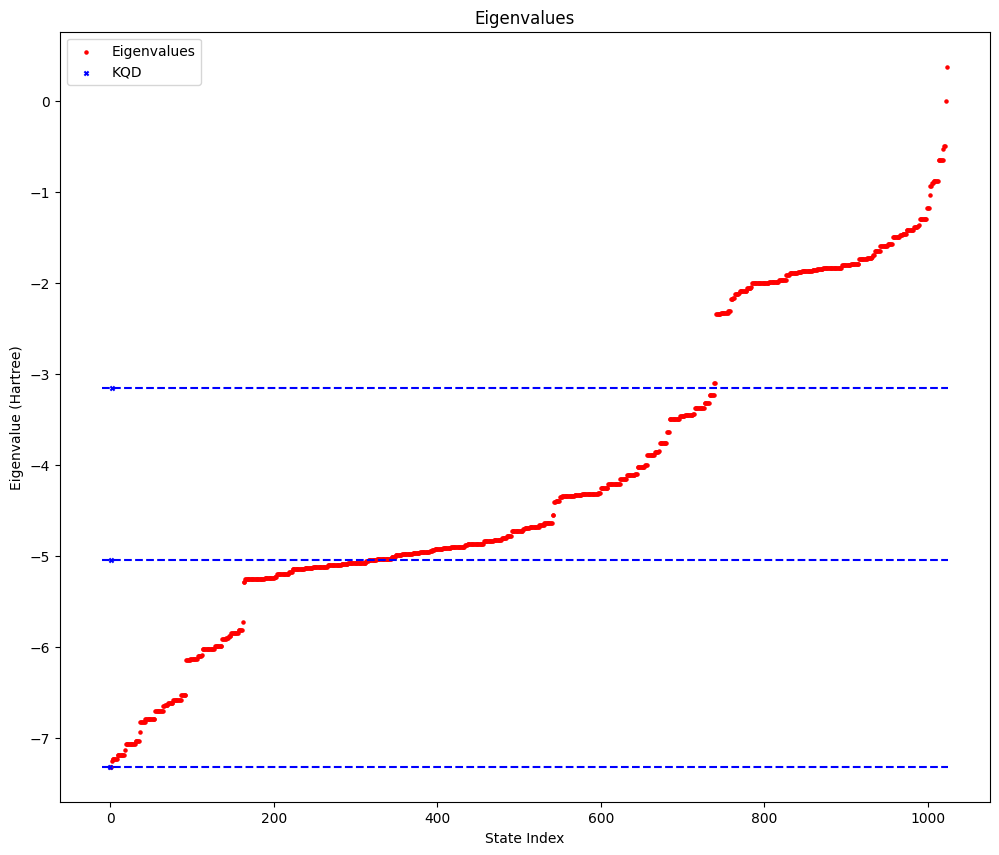

In [147]:
import matplotlib.pyplot as plt
import numpy as np


states = np.arange(len(exact_eva))  # Create state indices (0, 1, 2, ...)
kstate = np.arange(len(eigenvalues))

# Create a scatter plot
plt.figure(figsize=(12, 10))
plt.scatter(states, exact_eva, color="red", label="Eigenvalues", marker="o", s=5)
plt.scatter(kstate, eigenvalues, color="blue", label="KQD", marker="x", s=9)
# Add labels and title
for val in eigenvalues:
    plt.hlines(y=val, xmin=-10, xmax=1024, colors='blue', linestyles='--', linewidth=1.5)

plt.xlabel("State Index")
plt.ylabel("Eigenvalue (Hartree)")
plt.title("Eigenvalues")
# plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [148]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA, SPSA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

transformer = FreezeCoreTransformer(remove_orbitals=[3, 4], freeze_core=False)
electronic_structure_problem = transformer.transform(electronic_structure_problem)
ansatz = UCCSD(
    electronic_structure_problem.num_spatial_orbitals,
    electronic_structure_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        electronic_structure_problem.num_spatial_orbitals,
        electronic_structure_problem.num_particles,
        mapper,
    ),
)

estimator = Estimator()
# This first part sets the ground state solver
# see more about this part in the ground state calculation tutorial
solver = VQE(estimator, ansatz, COBYLA())
solver.initial_point = [0.0] * ansatz.num_parameters
gse = GroundStateEigensolver(mapper, solver)

# The qEOM algorithm is simply instantiated with the chosen ground state solver and Estimator primitive
qeom_excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)
qeom_results = qeom_excited_states_solver.solve(electronic_structure_problem)
cobyla_energy = qeom_results.computed_energies
cobyla_energy

<ipython-input-148-01240813e080>:20: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


array([-7.31563059, -7.23044938, -5.26370741, -5.24387151, -5.19827847,
       -5.10401573, -5.04614619, -1.96583849, -1.87269058])

In [149]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA, SPSA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

transformer = FreezeCoreTransformer(remove_orbitals=[3, 4], freeze_core=False)
electronic_structure_problem = transformer.transform(electronic_structure_problem)
ansatz = UCCSD(
    electronic_structure_problem.num_spatial_orbitals,
    electronic_structure_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        electronic_structure_problem.num_spatial_orbitals,
        electronic_structure_problem.num_particles,
        mapper,
    ),
)

estimator = Estimator()
# This first part sets the ground state solver
# see more about this part in the ground state calculation tutorial
solver = VQE(estimator, ansatz, SLSQP())
solver.initial_point = [0.0] * ansatz.num_parameters
gse = GroundStateEigensolver(mapper, solver)

# The qEOM algorithm is simply instantiated with the chosen ground state solver and Estimator primitive
qeom_excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)
qeom_results = qeom_excited_states_solver.solve(electronic_structure_problem)
slsqp_energy = qeom_results.computed_energies
slsqp_energy

<ipython-input-149-4657fd5f9ff7>:20: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


array([-7.31563075, -7.23044876, -5.26370714, -5.24387038, -5.19829265,
       -5.1040148 , -5.04614467, -1.96582173, -1.87268939])

In [150]:
eigenvalues

array([-7.31582811, -5.04744521, -3.15158127])

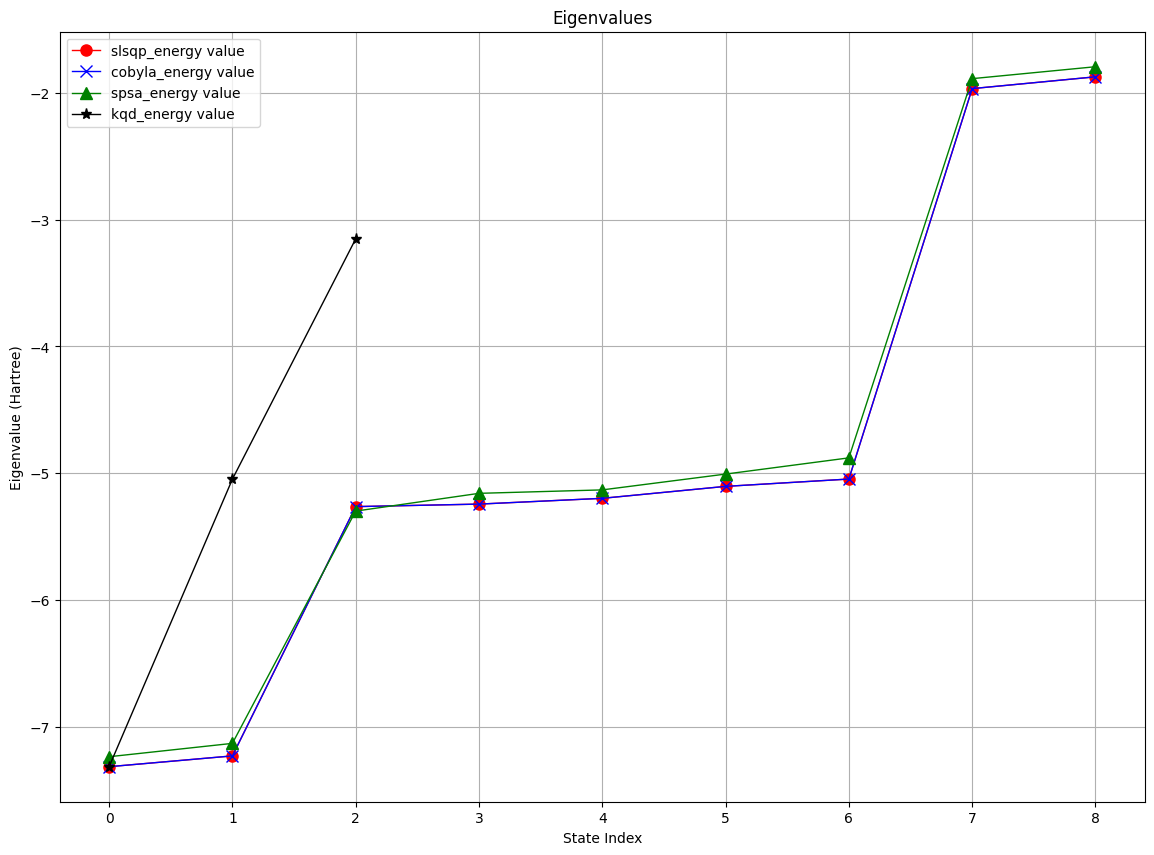

In [171]:
plt.figure(figsize=(14, 10))
state = np.arange(len(slsqp_energy))
plt.plot(state, slsqp_energy, color="red", label="slsqp_energy value", marker="o", linewidth=1.0, markersize=8)
plt.plot(state, cobyla_energy, color="blue", label="cobyla_energy value", marker="x",  linewidth=1.0, markersize=8)
plt.plot(state, spsa_energy, color="green", label="spsa_energy value", marker="^",  linewidth=1.0, markersize=8)
plt.plot(kstate, eigenvalues, color="black", label="kqd_energy value", marker="*",  linewidth=1.0, markersize=8)
plt.xlabel("State Index")
plt.ylabel("Eigenvalue (Hartree)")
plt.title("Eigenvalues")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()